In [1]:
from PIL import Image
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt

In [2]:
# if len(sys.argv) < 4:
#     print("Function requres 3 arguments")
#     sys.exit()
# else:
#     K = int(sys.argv[1])
#     if K < 3:
#         print("Error: K must be greater than 2")
#         sys.exit()
#         inputimageFileName = sys.argv[2]
#         outputimageFileName = sys.argv[3]

In [9]:
K = 5
image = Image.open('picasso.jpg')
width, height = image.size

In [10]:
img_px = image.load()
red = []
blue = []
green = []
x = []
y = []
for h in range(height):
    for w in range(width):
        red.append(img_px[w,h][0])
        blue.append(img_px[w,h][2])
        green.append(img_px[w,h][1])
        x.append(h)
        y.append(w)

img_matrix = np.column_stack((red, green, blue, x,y))

In [11]:
normalized_img= np.zeros((img_matrix.shape))
orig_img = img_matrix
normalized_img[:,0] = (img_matrix[:,0] - np.mean(img_matrix[:,0]))/ np.std(img_matrix[:,0])
normalized_img[:,1] = (img_matrix[:,1]- np.mean(img_matrix[:,1]))/ np.std(img_matrix[:,1])
normalized_img[:,2] = (img_matrix[:,2] - np.mean(img_matrix[:,2]))/ np.std(img_matrix[:,2])
normalized_img[:,3]  = (img_matrix[:,3] - np.mean(img_matrix[:,3]))/ np.std(img_matrix[:,3])
normalized_img[:,4] = (img_matrix[:,4] - np.mean(img_matrix[:,4]))/ np.std(img_matrix[:,4])


In [12]:
class Kmeans:
    def __init__(self, k=2, tol=0.001, max_iter=300):
        self.optimized_centroids = {}
        self.k = k
        self.tol = tol
        self.max_iter = max_iter

    ################################ Fit function ################################
    def fit(self,df):
        self.centroid_dict = {}

        for i in range(self.k):
            #initializing random points for rbg channels
            #shuffle a random number and pick k point randomly from the dataset
            init_pt = np.random.randint(0,df.shape[0])
            self.centroid_dict[i] = df[init_pt]
            
            
        #iterate over max_iter number of times
        for i in range(self.max_iter):
            #create an empty label dictonary
            self.label_dict = {}

            #create keys with k-values for the label dict - centroid
            for i in range(self.k):
                self.label_dict[i] = []

                
            ###############################
            for data in df:
                #calculate the euclidean distance
                euclidean_distances = [np.linalg.norm(data - self.centroid_dict[c]) for c in self.centroid_dict]
                label = euclidean_distances.index(min(euclidean_distances))
                self.label_dict[label].append(data)


            #hold the former centroid dict
            old_centroid_dict = dict(self.centroid_dict) 


            ###############################
            #re-calculates the centroids
            for label in self.label_dict:
                self.centroid_dict[label] = np.average(self.label_dict[label], axis = 0)


            converged = True

            for c in self.centroid_dict:
                old_center = old_centroid_dict[c]
                new_center = self.centroid_dict[c]

                if np.sum((new_center - old_center)/old_center * 100.0) > self.tol:
                    converged = False
                else:
                    converged = True

            #if converged, stop the iteration - the final centroids = the previously processed
            if converged == True:
                self.optimized_centroids = self.centroid_dict
                break
            #if not, continue the next iteration till the convergence meets
            else:
                continue

    def predict(self, data):
        euclidean_distances = [np.linalg.norm(data - self.optimized_centroids[c]) for c in self.centroid_dict]
        label = euclidean_distances.index(min(euclidean_distances))
        return label


In [13]:
# reconstruction of the image

kmeans = Kmeans(k=K)
kmeans.fit(normalized_img)



In [14]:
adj_img =[]
cluster=[]
for data in normalized_img:
    cluster =kmeans.predict(data)
    r = kmeans.optimized_centroids[cluster][0]
    g = kmeans.optimized_centroids[cluster][1]
    b = kmeans.optimized_centroids[cluster][2]
    data[:3] = r,g,b
    adj_img.append(data)
    
adj_img = np.asarray(adj_img)
adj_img

array([[ 1.05788692,  1.40342684,  1.50014474, -1.7262869 , -1.72469599],
       [ 1.05788692,  1.40342684,  1.50014474, -1.7262869 , -1.709955  ],
       [ 1.05788692,  1.40342684,  1.50014474, -1.7262869 , -1.69521401],
       ...,
       [ 1.05788692,  1.40342684,  1.50014474,  1.7262869 ,  1.69521401],
       [ 1.05788692,  1.40342684,  1.50014474,  1.7262869 ,  1.709955  ],
       [ 1.05788692,  1.40342684,  1.50014474,  1.7262869 ,  1.72469599]])

In [15]:
data = pd.DataFrame(adj_img, columns = ['r', 'g', 'b','x','y'])
#  Inverting the normalization of the image
data['r'] = (data['r']*np.std(img_matrix[:,0]))+np.mean(img_matrix[:,0])
data['g'] = (data['g']*np.std(img_matrix[:,1]))+np.mean(img_matrix[:,1])
data['b'] = (data['b']*np.std(img_matrix[:,2]))+np.mean(img_matrix[:,2])
data['x'] = orig_img[:,-2]
data['y'] = orig_img[:,-1]

In [16]:
matrix = np.asarray(image)
segmented_image = np.zeros((matrix.shape))
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        r = data[(data['x'] == i) & (data['y'] == j)]['r']
        g = data[(data['x'] == i) & (data['y'] == j)]['g']
        b = data[(data['x'] == i) & (data['y'] == j)]['b']
        segmented_image[i, j,0] = r
        segmented_image[i, j,1] = g
        segmented_image[i, j,2] = b

In [17]:
segmented_image

array([[[200.08687354, 204.2543406 , 181.44126339],
        [200.08687354, 204.2543406 , 181.44126339],
        [200.08687354, 204.2543406 , 181.44126339],
        ...,
        [200.08687354, 204.2543406 , 181.44126339],
        [200.08687354, 204.2543406 , 181.44126339],
        [200.08687354, 204.2543406 , 181.44126339]],

       [[200.08687354, 204.2543406 , 181.44126339],
        [200.08687354, 204.2543406 , 181.44126339],
        [200.08687354, 204.2543406 , 181.44126339],
        ...,
        [200.08687354, 204.2543406 , 181.44126339],
        [200.08687354, 204.2543406 , 181.44126339],
        [200.08687354, 204.2543406 , 181.44126339]],

       [[200.08687354, 204.2543406 , 181.44126339],
        [200.08687354, 204.2543406 , 181.44126339],
        [200.08687354, 204.2543406 , 181.44126339],
        ...,
        [200.08687354, 204.2543406 , 181.44126339],
        [200.08687354, 204.2543406 , 181.44126339],
        [200.08687354, 204.2543406 , 181.44126339]],

       ...,

      

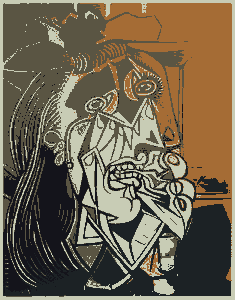

In [18]:
out_img = Image.fromarray(np.uint8(segmented_image))
# out_img.save(outimageFileName)
out_img

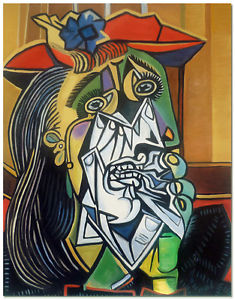

In [19]:
image